In [32]:
from minisom import MiniSom
import pandas as pd 
import numpy as np 

data = pd.read_csv("./hcvdat0.csv")

In [33]:
data.dtypes

Unnamed: 0      int64
Category       object
Age             int64
Sex            object
ALB           float64
ALP           float64
ALT           float64
AST           float64
BIL           float64
CHE           float64
CHOL          float64
CREA          float64
GGT           float64
PROT          float64
dtype: object

In [34]:
data = data.drop(["Unnamed: 0"],axis=1) 

In [35]:
# filling missing value
from sklearn import preprocessing
for i in data.columns:
    data[i].fillna(method = "ffill",inplace = True)


In [36]:
# change nominal attributes to numerical attributes
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data["Sex"] = le.fit_transform(data["Sex"])
data["Sex"] = data["Sex"].astype('float64')


In [37]:
#unsupervised learning need to drop the class column
Class =  data['Category']
Attributes = data.drop(['Category'],axis = 1)

In [63]:
Class

0      0
1      0
2      0
3      0
4      0
      ..
610    4
611    4
612    4
613    4
614    4
Name: Category, Length: 615, dtype: object

In [38]:
Attributes.dtypes

Age       int64
Sex     float64
ALB     float64
ALP     float64
ALT     float64
AST     float64
BIL     float64
CHE     float64
CHOL    float64
CREA    float64
GGT     float64
PROT    float64
dtype: object

In [39]:
# make type all become float, may not need this.
Attributes["Age"] = Attributes["Age"].astype('float64')


In [40]:
# we standardize each column(attribute) first
Attributes = preprocessing.scale(Attributes)

# then we make each row has unit length

for i in range(615):
    length = sum(map(lambda x: float(x**2), Attributes[i]))**0.5
    for j in range(len(Attributes[i])):
        Attributes[i][j] = Attributes[i][j]/length
print(Attributes)

[[-0.5086075   0.26350198 -0.17902513 ...  0.16484807 -0.16657788
  -0.18694197]
 [-0.595132    0.30832904 -0.20948096 ... -0.05688527 -0.17004822
   0.32077707]
 [-0.61287436  0.31752109  0.36583266 ...  0.03787778 -0.04633948
   0.53776653]
 ...
 [ 0.28940616 -0.22056058 -0.38302284 ... -0.05142119  0.07914696
   0.32353449]
 [-0.0417013  -0.37447456 -0.44412179 ... -0.17528042  0.05702043
  -0.05740687]
 [ 0.31403917 -0.3425672  -0.2648166  ... -0.0782232  -0.02757483
  -0.2038841 ]]


In [42]:
#16, 16 is the width and height of neurons. 
# sigma might be D 
som = MiniSom(16,16,12,sigma=1.5,learning_rate=0.5)
som.pca_weights_init(Attributes)
som.train(Attributes,1000,verbose=True) #1000 is the epochs 


 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.5809180148521413


In [43]:
#change nominal class value to number 
for i in range(len(Class)):
    if(Class[i] == "0=Blood Donor"):
        Class[i] = 0
    elif Class[i] == "0s=suspect Blood Donor":
        Class[i] = 1
    elif Class[i] == "1=Hepatitis":
        Class[i] = 2
    elif Class[i] == "2=Fibrosis":
        Class[i] = 3
    elif Class[i] == "3=Cirrhosis":
        Class[i] = 4

In [66]:
a = ["a","b","c","d"]
for i, j in enumerate(a):
    print(f"{i} : {j}")

0 : a
1 : b
2 : c
3 : d


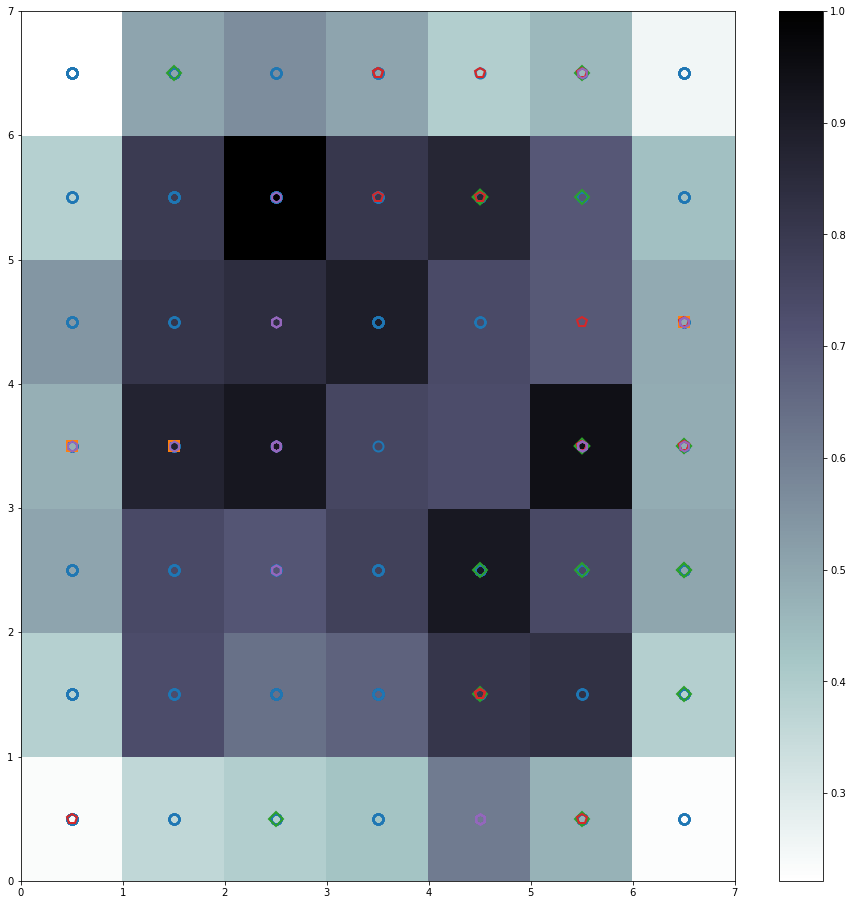

In [65]:

import matplotlib.pyplot as plt

plt.figure(figsize=(16, 16))

plt.pcolor(som.distance_map().T, cmap='bone_r')  # plotting the distance map as background
plt.colorbar()
markers = ['o', 's', 'D','p','h']  # circle, square, Diamond, pentagon, hexigon
colors = ['C0', 'C1', 'C2','C3','C4']
for cnt, xx in enumerate(Attributes):
    w = som.winner(xx)  # getting the winner, format is (w[0],w[1]), like coordinates
    plt.plot(w[0]+.5, w[1]+.5, markers[Class[cnt]], markerfacecolor='None', # we draw dots. 
             markeredgecolor=colors[Class[cnt]], markersize=10, markeredgewidth=2)

plt.show()

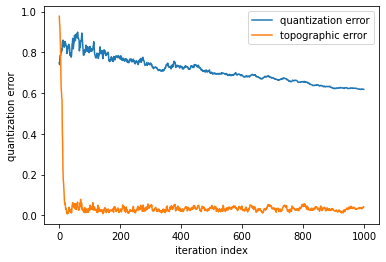

In [45]:
som = MiniSom(10, 20, 12, sigma=3., learning_rate=.7,
              neighborhood_function='gaussian', random_seed=10)

max_iter = 1000
q_error = []
t_error = []

for i in range(max_iter):
    rand_i = np.random.randint(len(Attributes))
    som.update(Attributes[rand_i], som.winner(Attributes[rand_i]), i, max_iter)
    q_error.append(som.quantization_error(Attributes))
    t_error.append(som.topographic_error(Attributes))

plt.plot(np.arange(max_iter), q_error, label='quantization error')
plt.plot(np.arange(max_iter), t_error, label='topographic error')
plt.ylabel('quantization error')
plt.xlabel('iteration index')
plt.legend()
plt.show()

In [46]:
def classify(som, data):
    winmap = som.labels_map(X_train, y_train)
    default_class = np.sum(list(winmap.values())).most_common()[0][0]
    result = []
    for d in data:
        win_position = som.winner(d)
        if win_position in winmap:
            result.append(winmap[win_position].most_common()[0][0])
        else:
            result.append(default_class)
    return result

Classification

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

array_class = []
for i in range(len(Class)):
    array_class.append(Class[i])

X_train, X_test, y_train, y_test = train_test_split(Attributes, array_class, stratify=array_class)

som = MiniSom(7, 7, 12, sigma=3, learning_rate=0.5, 
              neighborhood_function='triangle', random_seed=10)
som.pca_weights_init(X_train)
som.train_random(X_train, 500, verbose=False)

classes = ["Blood Donor","suspect Blood Donor","Hepatitis","Fibrosis","Cirrhosis"]
print(classification_report(y_test, classify(som, X_test),target_names = classes) )

                     precision    recall  f1-score   support

        Blood Donor       0.91      0.96      0.94       133
suspect Blood Donor       0.00      0.00      0.00         2
          Hepatitis       0.33      0.50      0.40         6
           Fibrosis       0.00      0.00      0.00         5
          Cirrhosis       1.00      0.62      0.77         8

           accuracy                           0.88       154
          macro avg       0.45      0.42      0.42       154
       weighted avg       0.85      0.88      0.87       154

